In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import pi,sin,cos,sqrt,log,floor

import camb
import healpy as hp
import astropy.units as u

import emcee
import corner
from multiprocessing import Pool
np.random.seed(22)

%matplotlib inline

In [2]:
cmap=cm.RdBu_r
cmap.set_under('w')

cmapseismic=cm.seismic
cmapseismic.set_under('w')

# Data downloads

## CMB Temperature Fluctuation Map

In [6]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits

--2023-03-23 01:15:23--  https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.110
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2013312960 (1.9G) [image/x-fits]
Saving to: ‘COM_CMB_IQU-smica_2048_R3.00_full.fits’

       COM_CMB_IQU-   0%[                    ]  72.00K  47.5KB/s               ^C


## Planck Binned Power Spectrum

In [ ]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-TT-binned_R3.01.txt

--2023-03-18 19:23:38--  https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-TT-binned_R3.01.txt
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.110
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7143 (7.0K) [text/plain]
Saving to: ‘COM_PowerSpect_CMB-TT-binned_R3.01.txt.1’

COM_PowerSpect_CMB- 100%[===================>]   6.98K  --.-KB/s    in 0s      

2023-03-18 19:23:40 (197 MB/s) - ‘COM_PowerSpect_CMB-TT-binned_R3.01.txt.1’ saved [7143/7143]



# Visualizing the data

In [3]:
#Read in Planck data
planck_map = hp.read_map('COM_CMB_IQU-smica_2048_R3.00_full.fits')

#Read in binned power spectra from Planck 2018 data
powerspec_rls = np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt')

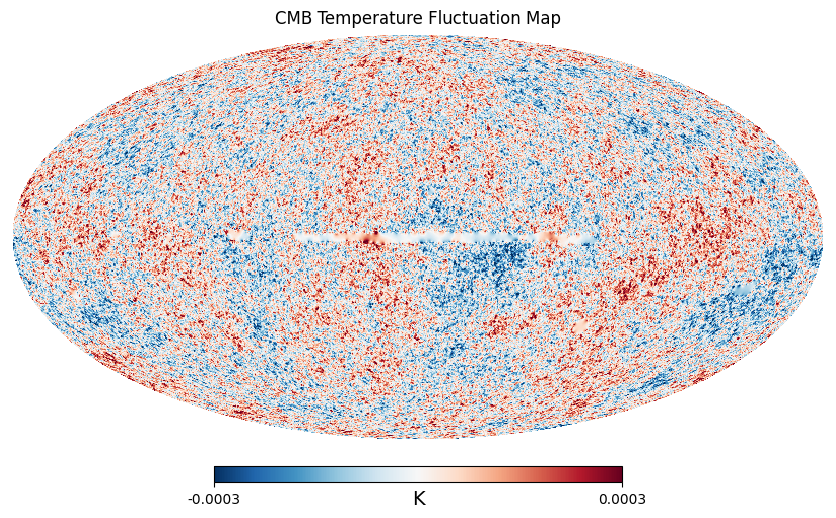

In [23]:
hp.mollview(planck_map, min=-3e-4, max=3e-4, title="CMB Temperature Fluctuation Map", unit="K",cmap=cmap)

# Computing the Observed Power Spectrum

In [5]:
cl_map = hp.anafast(planck_map,lmax=2500,use_pixel_weights=True)

In [6]:
ll = np.arange(len(cl_map))
cl_map = (ll*(ll+1)*cl_map/(2*pi))/1e-12

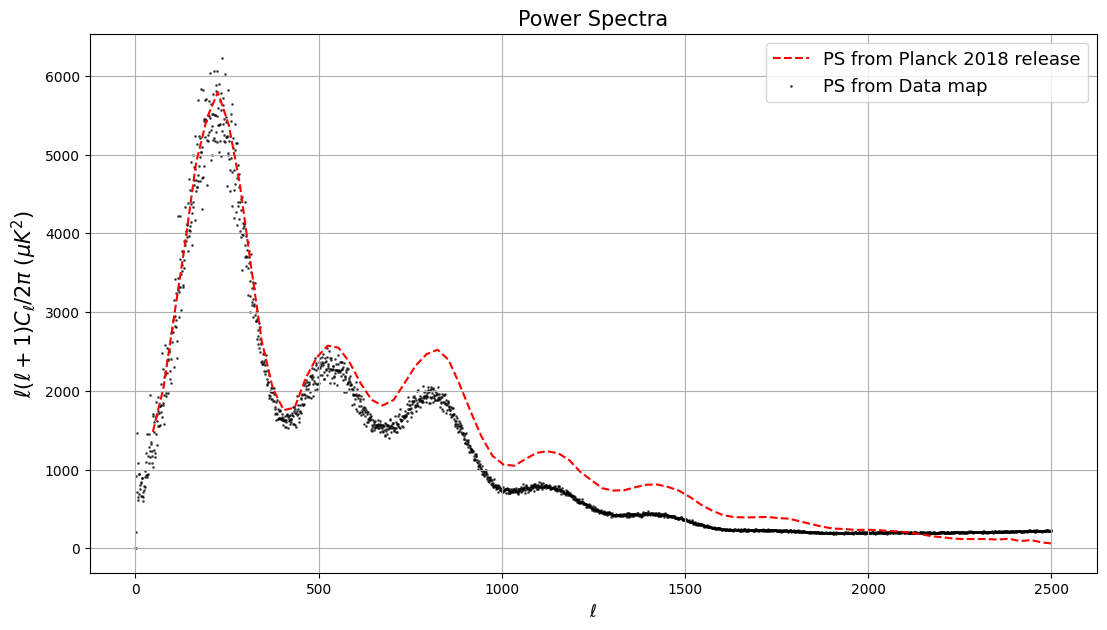

In [7]:
ll = np.arange(len(cl_map))

plt.figure(figsize=(13,7))
plt.plot(powerspec_rls[:,0],powerspec_rls[:,1],'r--',label='PS from Planck 2018 release')
plt.scatter(ll,cl_map,s=1,c='k',label='PS from Data map',alpha=0.6)

plt.xlabel(r'$\ell$',fontsize=12)
plt.ylabel(r'$\ell(\ell+1) C_\ell/2\pi~(\mu K^2)$',fontsize=15)
plt.title('Power Spectra',fontsize=15)
plt.legend(fontsize=13)
plt.grid()

# Corrections for beam

In [8]:
w_ll = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=2500)

In [9]:
cl_cmb = cl_map/w_ll**2

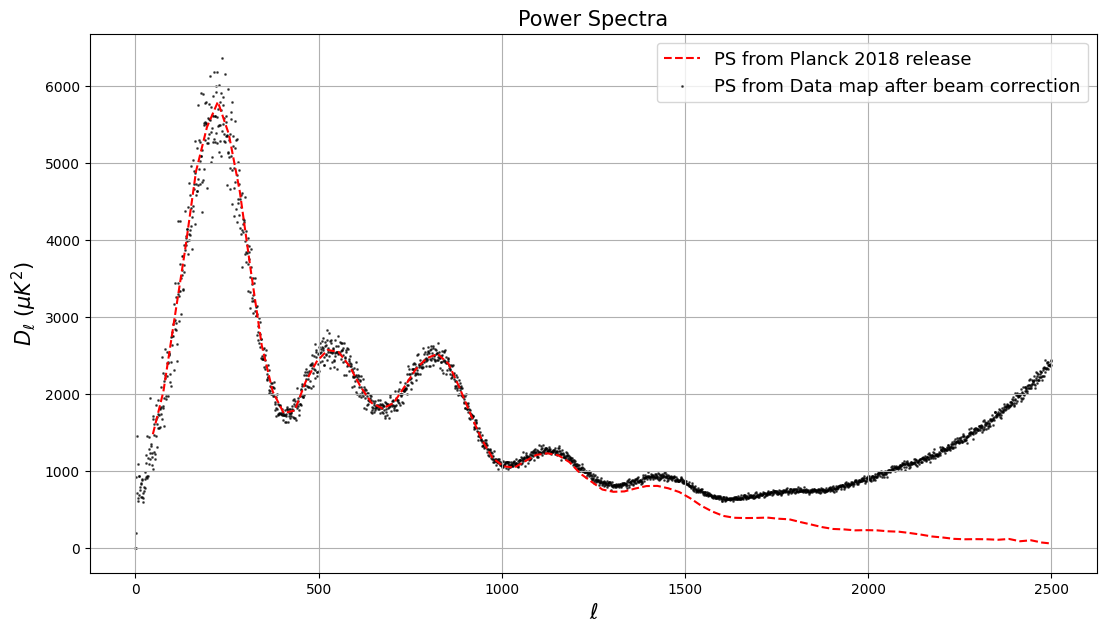

In [10]:
ll = np.arange(len(cl_map))

plt.figure(figsize=(13,7))
plt.plot(powerspec_rls[:,0], powerspec_rls[:,1],'r--', alpha=1, label='PS from Planck 2018 release')
plt.scatter(ll, cl_cmb, alpha=0.6,s=1,c='k', label='PS from Data map after beam correction')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$D_\ell~(\mu K^2)$',fontsize=15)
plt.title('Power Spectra',fontsize=15)
plt.grid()
plt.legend(loc='best',fontsize=13)

# Model Power Spectrum

In [11]:
def model_powerspec(H0,ombh2,omch2,lmax):
    cp = camb.model.CAMBparams()
    cp.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,tau=0.054,nnu=2.99)
    cp.set_for_lmax(lmax)
    results = camb.get_results(cp)
    totCL = results.get_cmb_power_spectra(cp,lmax=lmax,spectra=['total'],CMB_unit='muK')['total']
    
    return totCL[:,0]

# MCMC

In [12]:
ll = np.arange(0,1025)
cl_cmb_fitting = cl_cmb[0:1025]

def log_likelihood(theta): #theta = [H0,ombh2,omch2,sigma]
    ps_theory = model_powerspec(theta[0],theta[1],theta[2],lmax=1024)
    ps_obs = cl_cmb_fitting
    sigma = theta[3]
    return -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (ps_obs - ps_theory)**2/sigma**2)

theta_min =[50,0.009,0.08,50]
theta_max =[90,0.04,0.14,500]

def log_prior(theta):
    if np.any(theta < theta_min) or np.any(theta > theta_max):
        return -np.inf
    else:
        return 0

def log_posterior(theta):
    if np.isinf(log_prior(theta)):
        return log_prior(theta)
    else:
        return log_likelihood(theta)+log_prior(theta)

In [13]:
ndim = 4
nwalkers = 50
backend = emcee.backends.HDFBackend("logfile_run1.h5")
  
starting_guesses = []

for i in range(nwalkers):    
    starting_guesses.append([random.uniform(50,80),random.uniform(0.009,0.04),random.uniform(0.08,0.14),random.uniform(50,500)])

In [14]:
backend.reset(len(starting_guesses),ndim)

nsteps = 500

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, backend=backend)
coords, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|███████████████████████████████████████| 500/500 [7:48:34<00:00, 56.23s/it]


Text(0, 0.5, '$\\sigma$')

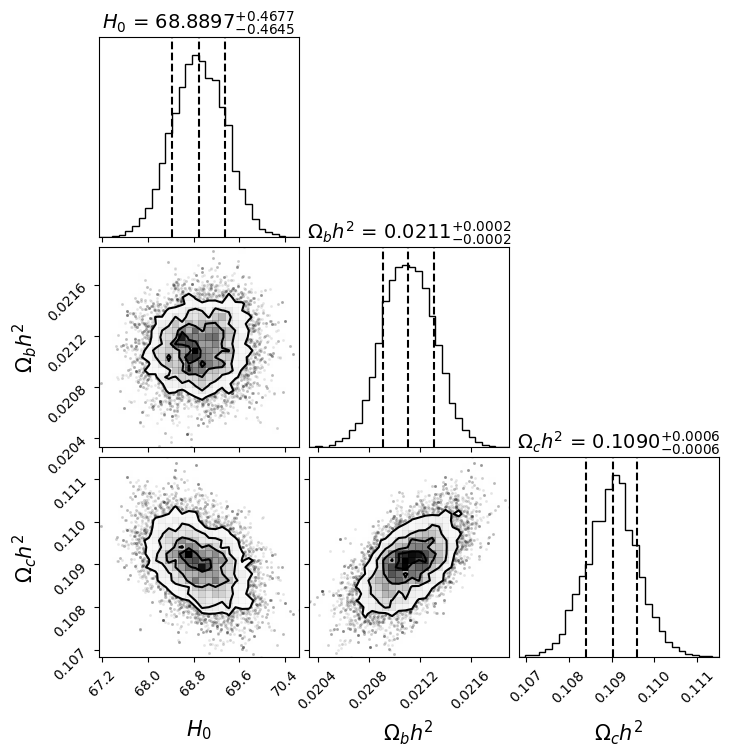

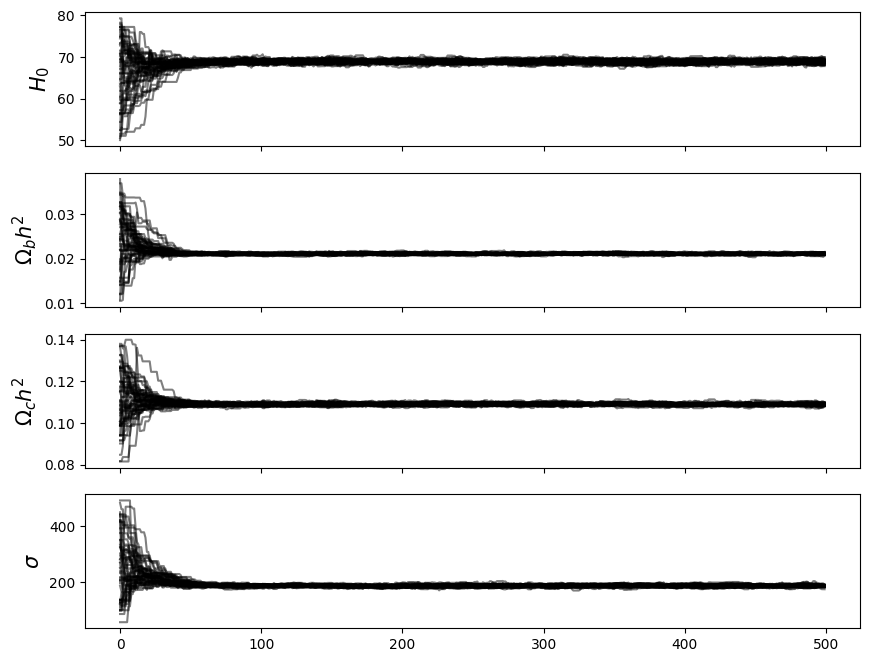

In [22]:
reader = emcee.backends.HDFBackend("logfile_run1.h5")
burnin = 100

figure = corner.corner(reader.get_chain(flat=True, discard=burnin)[:,0:3],bins=30,labels=[r'$H_0$',r'$\Omega_b h^2$',r'$\Omega_c h^2$'], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f',title_kwargs={"fontsize": 14},label_kwargs={"fontsize":15})
plt.savefig(f'Corner_final.png',dpi=500)

fig, ax = plt.subplots(4, sharex=True,figsize=(10,8))

for i in range(4):
    ax[i].plot(reader.get_chain()[:, :, i],'-k', alpha=0.5)
    
ax[0].set_ylabel(r'$H_0$',fontsize=15)
ax[1].set_ylabel(r'$\Omega_b h^2$',fontsize=15)
ax[2].set_ylabel(r'$\Omega_c h^2$',fontsize=15)
ax[3].set_ylabel(r'$\sigma$',fontsize=15)

# Best Fit

In [24]:
best_fit_cp = reader.get_chain(flat=True)[:,0:3][-1]
best_fit_ps = model_powerspec(best_fit_cp[0],best_fit_cp[1],best_fit_cp[2],lmax = 1024)

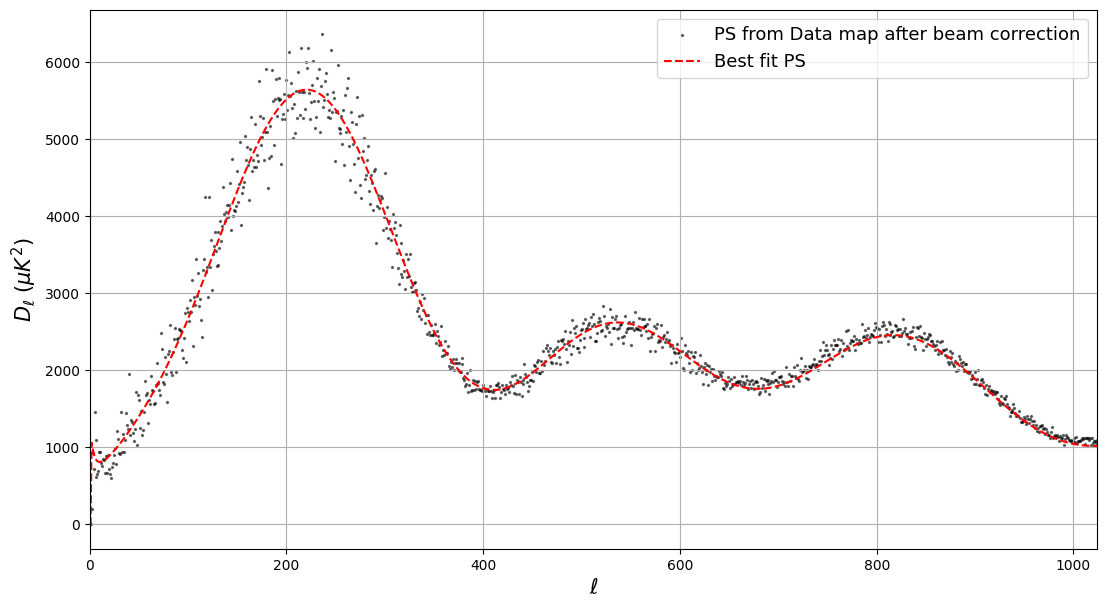

In [25]:
ll = np.arange(len(cl_cmb_fitting))

plt.figure(figsize=(13,7))
plt.scatter(ll, cl_cmb_fitting, alpha=0.5,s=2,c='k', label='PS from Data map after beam correction')
plt.plot(ll, best_fit_ps,'r--', label='Best fit PS')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$D_\ell~(\mu K^2)$',fontsize=15)
plt.grid()
plt.xlim(0,1024)
plt.legend(loc='best',fontsize=13)